<a href="https://colab.research.google.com/github/SeeMeInCrown/Decoding-Brain-Reconstruct-visual-stimuli-image-from-brain-signals/blob/main/F_2photon_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapt the proper environment

In [4]:
!pip install "opencv-python-headless<4.3"
!pip install suite2p

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.4/661.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [56]:
!pip install deepcad

  Using cached deepcad-1.2.0-py3-none-any.whl
  Using cached csbdeep-0.7.4-py2.py3-none-any.whl (69 kB)
  Using cached gdown-4.2.0-py3-none-any.whl
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [77]:
!pip install opencv-python-headless
!pip install pillow
!pip install tifffile

In [169]:
from suite2p import io, default_ops
from suite2p.registration import bidiphase as bidi
from suite2p.registration import utils, rigid, nonrigid
from suite2p.detection import sourcery, sparsedetect, chan2detect, utils
from suite2p.detection.stats import roi_stats
from suite2p.detection.denoise import pca_denoise
from suite2p.io.binary import BinaryFile
from suite2p.classification import classify, user_classfile
classfile = suite2p.classification.builtin_classfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os, requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import suite2p

In [27]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': True,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

<ipython-input-27-1404daa3a31c>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap('jet')


In [28]:
# Test the data connnection and print shape
fname = "/content/drive/MyDrive/Zhaolab_THU/MA1/MA1-1.tif"
url = "https://drive.google.com/file/d/1iYpMaarNNfpn_SQpWsr9cIW2AD-F-J_V/view?usp=drive_link"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to get data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to get data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

from tifffile import imread
data = imread(fname)
print('imaging data of shape: ', data.shape)
n_time, Ly, Lx = data.shape

imaging data of shape:  (2013, 512, 512)


# Enhancement and Denoising


Displaying the first raw file -----> 
/content/drive/MyDrive/Zhaolab_THU/test_one_day/MA1.tif


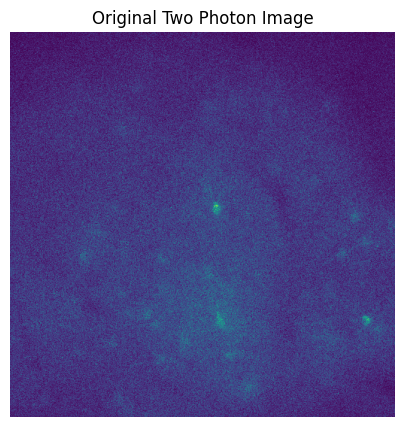

In [79]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib as mpl
import numpy as np
import tifffile as tiff
from deepcad.train_collection import training_class
from deepcad.movie_display import display, display_img
from deepcad.utils import get_first_filename, download_demo
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5,5)
display_images = True
datasets_path = '/content/drive/MyDrive/Zhaolab_THU/test_one_day'
Output_path = '/content/drive/MyDrive/Zhaolab_THU/enhance_denoise'
if display_images:
    display_filename = get_first_filename(datasets_path)
    print('\033[1;31mDisplaying the first raw file -----> \033[0m')
    print(display_filename)
    img = Image.open(display_filename)
    img_original = np.asarray(img)
    plt.imshow(img_original)
    plt.title('Original Two Photon Image')
    plt.axis('off')
    plt.show()
    #plt.imshow()

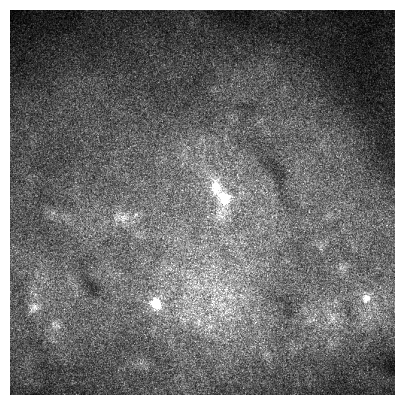

In [71]:
# normalize the image and display
img = display_img(display_filename,norm_min_percent=1, norm_max_percent=99)
plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
plt.axis('off')
plt.show()

Enhanced image saved to /content/drive/MyDrive/Zhaolab_THU/enhance_denoise/MA1.tif


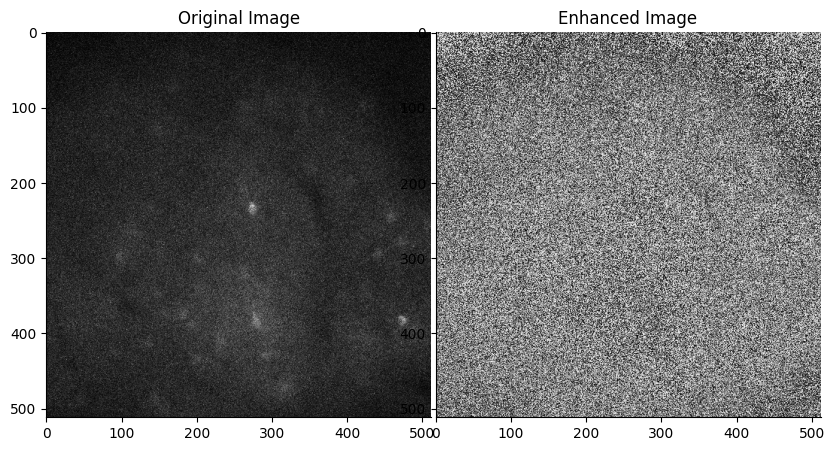

In [110]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    image_float = image.astype(np.float32) / 255.0
    adjusted_image = np.power(image_float, invGamma) * 255
    return adjusted_image.astype(np.uint8)

def enhance_image(image_path, output_path):
    image = tiff.imread(image_path)

    # Convert the multi-dimensional tiff image to a list of 2D grayscale images
    frames = [frame for frame in image]

    enhanced_frames = []
    for frame in frames:
        # Adjust backlight and exposure
        adjusted_frame = adjust_gamma(frame, 1.5)

        # Denoise the image
        denoised_frame = cv2.fastNlMeansDenoising(adjusted_frame, None, 3, 3, 5)

        enhanced_frames.append(denoised_frame)

    enhanced_image = np.stack(enhanced_frames, axis=0)
    tiff.imwrite(output_path, enhanced_image)

def display_comparison(input_path, output_path):
    original_image = tiff.imread(input_path)
    enhanced_image = tiff.imread(output_path)

    # Display the first frame of both original and enhanced images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image[0], cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(enhanced_image[0], cmap='gray')
    ax[1].set_title("Enhanced Image")
    plt.show()

def enhance_and_compare(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.endswith(".tif"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            enhance_image(input_path, output_path)
            print(f"Enhanced image saved to {output_path}")

            display_comparison(input_path, output_path)
            break  # Show only one example


input_folder = datasets_path
output_folder = Output_path

if not os.path.exists(output_folder):
  os.makedirs(output_folder)

enhance_and_compare(input_folder, output_folder)

In [55]:
!pip install deepcad

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for deepcad: filename=deepcad-1.2.0-py3-none-any.whl size=28820 sha256=edcc8fd1a774ee24fe629b70d859847f8f29ddb79b3842383a0c5c1c75111ef5
  Stored in directory: /root/.cache/pip/wheels/18/54/a5/a5f901bad5d10717a947553186446b015d02a3b0bc33916c7a
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14245 sha256=e1d2b897cd06efed4e58b1c8d21a569c91eb8f9bbd0971d335d1174ca6d2b99a
  Stored in directory: /root/.cache/pip/wheels/31/b7/72/73b6cdc08de365f05e0d09a6492a95cb7862c5025683c51761
Successfully built deepcad gdown
ERROR: Operation cancelled by user


In [ ]:
import torch

if torch.cuda.is_available():
    print('\033[1;31mGPU accessiable. Use GPU for computation.\033[0m')
    gpu_id = torch.cuda.current_device()
    total_memory = torch.cuda.get_device_properties(gpu_id).total_memory/1024/1024
    alloc_memory = torch.cuda.memory_allocated(0)/1024/1024
    print('GPU ID: ', gpu_id, '|', torch.cuda.get_device_name(), \
          '| Memory: {:.0f} MB'.format(total_memory))
    ! nvcc --version
    print('PyTorch version: ', torch.__version__)
else:
    print('\033[1;31mNo GPU support. Please enable GPUs for the notebook:\033[0m')
    print(' 1. Navigate to Edit → Notebook Settings')
    print(' 2. Select GPU from the Hardware Accelerator drop-down')

GPU accessiable. Use GPU for computation.
GPU ID:  0 | Tesla T4 | Memory: 15102 MB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
PyTorch version:  2.2.1+cu121


# Deepcad training

In [ ]:
from deepcad.train_collection import training_class
from deepcad.movie_display import display, display_img
from deepcad.utils import get_first_filename, download_demo

* the datasets and the saved model
* data in /content/datasets
* model in /content/pth

In [ ]:
#file_name=
datasets_path = '/content/drive/MyDrive/Zhaolab_THU/MA1'

Displaying the first raw file -----> 
/content/drive/MyDrive/Zhaolab_THU/test_one_day/MA1.tif


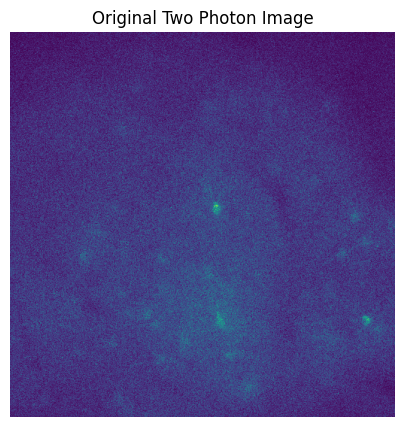

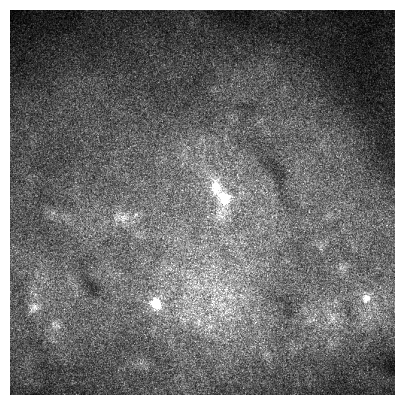

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib as mpl
import numpy as np
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5,5)
display_images = True

if display_images:
    display_filename = get_first_filename(datasets_path)
    print('\033[1;31mDisplaying the first raw file -----> \033[0m')
    print(display_filename)
    img = Image.open(display_filename)
    img_original = np.asarray(img)
    plt.imshow(img_original)
    plt.title('Original Two Photon Image')
    plt.axis('off')
    plt.show()
    #plt.imshow()
    # normalize the image and display
    img2 = display_img(display_filename,norm_min_percent=1, norm_max_percent=99)
    plt.imshow(img2,cmap=plt.cm.gray,vmin=0,vmax=255)
    plt.axis('off')
    plt.show()

## (do not need to run, cause I already get the trained model) Set the DeepCAD parameters for training
* Recommanded: DeepCAD need few shot training, just set n_epochs=2 and train_data_sizes=2000
* But increasing n_epochs and train_data_sizes can result better performance
* Another optimal setting is n_epochs=5, train_data_sizes=6000


In [ ]:
n_epochs = 2                # number of training epochs
GPU = '0'                   # the index of GPU you will use (e.g. '0', '0,1', '0,1,2')
train_datasets_size = 2000  # datasets size for training (how many 3D patches)
patch_xyt = 40             # the width, height, and length of 3D patches (use isotropic patch size by default) should be a factor of the total frames.
overlap_factor = 0.4        # the overlap factor between two adjacent patches
num_workers = 0             # if you use Windows system, set this to 0.

# Setup some parameters for result visualization during training period (optional)
save_test_images_per_epoch = True  # whether to save result images after each epoch

## (also do not need to run) Training object: pass all parameters as a dictionary

In [ ]:
train_dict = {
    # dataset dependent parameters
    'patch_x': patch_xyt,                          # the width of 3D patches
    'patch_y': patch_xyt,                          # the height of 3D patches
    'patch_t': patch_xyt,                          # the time dimension (frames) of 3D patches
    'overlap_factor':overlap_factor,               # the factor for image intensity scaling
    'scale_factor': 1,                             # the factor for image intensity scaling
    'select_img_num': 2000,                        # select the number of images used for training (use 2000 frames in colab)
    'train_datasets_size': train_datasets_size,    # datasets size for training (how many 3D patches)
    'datasets_path': datasets_path,                # folder containing files for training
    'pth_dir': './pth',                            # the path for pth file and result images

    # network related parameters
    'n_epochs': n_epochs,                          # the number of training epochs
    'lr': 0.00005,                                 # learning rate
    'b1': 0.5,                                     # Adam: bata1
    'b2': 0.999,                                   # Adam: bata2
    'fmap': 16,                                    # model complexity
    'GPU': GPU,                                    # GPU index
    'num_workers': num_workers,                    # if you use Windows system, set this to 0.
    'visualize_images_per_epoch': False,                       # whether to show result images after each epoch
    'save_test_images_per_epoch': save_test_images_per_epoch,  # whether to save result images after each epoch
    'colab_display': True
}
tc = training_class(train_dict)

Training parameters -----> 
{'overlap_factor': 0.4, 'datasets_path': '/content/drive/MyDrive/Zhaolab_THU/MA1', 'n_epochs': 2, 'fmap': 16, 'output_dir': './results', 'pth_dir': './pth', 'onnx_dir': './onnx', 'batch_size': 1, 'patch_t': 40, 'patch_x': 40, 'patch_y': 40, 'gap_y': 24, 'gap_x': 24, 'gap_t': 24, 'lr': 5e-05, 'b1': 0.5, 'b2': 0.999, 'GPU': '0', 'ngpu': 1, 'num_workers': 0, 'scale_factor': 1, 'train_datasets_size': 2000, 'select_img_num': 2000, 'test_datasize': 400, 'visualize_images_per_epoch': False, 'save_test_images_per_epoch': True, 'colab_display': True, 'result_display': ''}


## (also do not need to run) Start training
* The training models and results are stored in /content/pth

In [ ]:
tc.run()

Image list for training -----> 
Total stack number ----->  2
Noise image name ----->  MA1-1.tif
Noise image shape ----->  (2000, 512, 512)
Noise image name ----->  MA1-2.tif
Noise image shape ----->  (40, 512, 512)
Using 1 GPU(s) for training -----> 
[Epoch 1/2] [Batch 2400/2400] [Total loss: 8909.58, L1 Loss: 101.35, L2 Loss: 17717.82] [ETA: 0:01:04] [Time cost: 47 s]      
 Testing model of epoch 1 on the first noisy file ----->
Testing image name ----->  MA1-1.tif
Testing image shape ----->  (400, 512, 512)
 [Patch 7056/7056] [Time Cost: 43 s] [ETA: 0 s]      
 
[Epoch 2/2] [Batch 2400/2400] [Total loss: 4109.86, L1 Loss: 71.47, L2 Loss: 8148.25] [ETA: 0:00:00] [Time cost: 142 s]      
 Testing model of epoch 2 on the first noisy file ----->
Testing image name ----->  MA1-1.tif
Testing image shape ----->  (400, 512, 512)
 [Patch 7056/7056] [Time Cost: 42 s] [ETA: 0 s]      
 
 Training finished. All models saved to disk.


## Run the DeepCAD pipline


In [ ]:
from deepcad.test_collection import testing_class
from deepcad.movie_display import display, display_img
from deepcad.utils import get_first_filename, download_demo

* data need to be processed path
* denoise model path

In [ ]:
 datasets_path ='/content/drive/MyDrive/Zhaolab_THU/test_one_day'
 denoise_model ='MA1_202403291001'

Set the parameters for DeepCAD


In [ ]:
test_datasize = 400                   # the number of slices to be tested
GPU = '0'                             # the index of GPU you will use for computation (e.g. '0', '0,1', '0,1,2')
patch_xyt = 40                       # the width, height, length of 3D patches
overlap_factor = 0.6        # the overlap factor between two adjacent patches
# Since the receptive field of 3D-Unet is ~90, seamless stitching requires an overlap (patch_xyt*overlap_factor）of at least 90 pixels
num_workers = 2                       # if you use Windows system, set this to 0.

### Runing algorithm with specified parameters

In [ ]:
test_dict = {
    # dataset dependent parameters
    'patch_x': patch_xyt,               # the width of 3D patches
    'patch_y': patch_xyt,               # the height of 3D patches
    'patch_t': patch_xyt,               # the time dimension (frames) of 3D patches
    'overlap_factor':overlap_factor,    # overlap factor
    'scale_factor': 1,                  # the factor for image intensity scaling
    'test_datasize': test_datasize,     # the number of frames to be tested
    'datasets_path': datasets_path,     # folder containing all files to be tested
    'pth_dir': '/content/drive/MyDrive/Zhaolab_THU/pth_1/',                 # pth file root path
    'denoise_model' : denoise_model,    # A folder containing all models to be tested
    'output_dir' : '/content/drive/MyDrive/Zhaolab_THU/results',         # result file root path
    # network related parameters
    'fmap': 16,                         # number of feature maps
    'GPU': GPU,                         # GPU index
    'num_workers': num_workers,         # if you use Windows system, set this to 0.
    'visualize_images_per_epoch': False,# whether to display inference performance after each epoch
    'save_test_images_per_epoch': True, # whether to save inference image after each epoch in pth path
    'colab_display': True
}

tc = testing_class(test_dict)

Testing parameters -----> 
{'overlap_factor': 0.6, 'datasets_path': '/content/drive/MyDrive/Zhaolab_THU/test_one_day', 'fmap': 16, 'output_dir': '/content/drive/MyDrive/Zhaolab_THU/results', 'pth_dir': '/content/drive/MyDrive/Zhaolab_THU/pth_1/', 'batch_size': 1, 'patch_t': 40, 'patch_x': 40, 'patch_y': 40, 'gap_y': 16, 'gap_x': 16, 'gap_t': 16, 'GPU': '0', 'ngpu': 1, 'num_workers': 2, 'scale_factor': 1, 'test_datasize': 400, 'denoise_model': 'MA1_202403291001', 'visualize_images_per_epoch': False, 'colab_display': True, 'result_display': ''}


### Start DeepCAD denoising
* all results will be in /content/.../results.

In [ ]:
tc.run()

Stacks for processing -----> 
Total stack number ----->  1
MA1.tif
Using 1 GPU(s) for testing -----> 
Testing the last model by default:
[Model 1/1, E_02_Iter_2400.pth] [Stack 1/1, MA1.tif] [Patch 18259/18259] [Time Cost: 348 s] [ETA: 0 s]      
 Testing finished. All results saved to disk.


### Display the DeepCAD processed data

Displaying denoised file of the last epoch-----> 
/content/drive/MyDrive/Zhaolab_THU/results//DataFolderIs_test_one_day_202403291008_ModelFolderIs_MA1_202403291001//E_02_Iter_2400//MA1_E_02_Iter_2400_output.tif


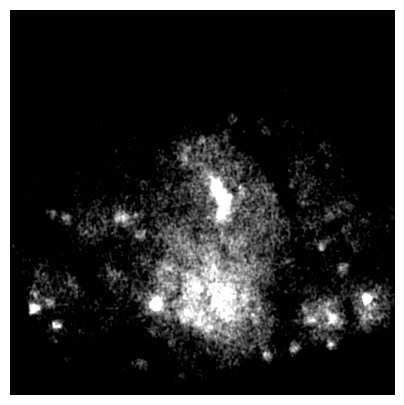

In [ ]:
if display_images:
    display_filename = tc.result_display
    print('\033[1;31mDisplaying denoised file of the last epoch-----> \033[0m')
    print(display_filename)

    # normalize the image and display
    img = display_img(display_filename,norm_min_percent=70, norm_max_percent=99)
    plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
    plt.axis('off')
    plt.show()

# The Main Registration and Segmentation




## Set pipeline parameters

### Main settings
These are the essential settings that are dataset-specific.

nplanes: (int, default: 1) each tiff has this many planes in sequence

nchannels: (int, default: 1) each tiff has this many channels per plane

functional_chan: (int, default: 1) this channel is used to extract functional ROIs (1-based, so 1 means first channel, and 2 means second channel)

tau: (float, default: 1.0) The timescale of the sensor (in seconds), used for deconvolution kernel. The kernel is fixed to have this decay and is not fit to the data.

0.7 for GCaMP6f

1.0 for GCaMP6m

1.25-1.5 for GCaMP6s

force_sktiff: (boolean, default: False) specifies whether or not to use scikit-image for reading in tiffs

fs: (float, default: 10.0) Sampling rate (per plane). For instance, if you have a 10 plane recording acquired at 30Hz, then the sampling rate per plane is 3Hz, so set ops[‘fs’] = 3.

do_bidiphase: (bool, default: False) whether or not to compute bidirectional phase offset from misaligned line scanning experiment (applies to 2P recordings only).

bidiphase: (int, default: 0) bidirectional phase offset from line scanning. If set to any value besides 0, then this offset is used and applied to all frames in the recording.

bidi_corrected: (bool, default: False) Specifies whether to do bidi correction.

frames_include: (int, default: -1) if greater than zero, only frames_include frames are processed. useful for testing parameters on a subset of data.

multiplane_parallel: (boolean, default: False) specifies whether or not to run pipeline on server

ignore_flyback: (list[ints], default: empty list) specifies which planes will be ignored as flyback planes by the pipeline.

In [33]:
ops = suite2p.default_ops()
ops['batch_size'] = 200 # we will decrease the batch_size in case low RAM on computer
ops['threshold_scaling'] = 2.0 # we are increasing the threshold for finding ROIs to limit the number of non-cell ROIs found (sometimes useful in gcamp injections)
ops['fs'] = 13 # sampling rate of recording, determines binning for cell detection
ops['tau'] = 1.25 # timescale of gcamp to use for deconvolution
ops['data_path']='/content/drive/MyDrive/Zhaolab_THU/test_one_day' # the file path, could be overwrite by db
print(ops)

{'suite2p_version': '0.14.4', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': '', 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.25, 'fs': 13, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': True, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 200, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'non

## Set Data Path
`ops` and `db` are functionally equivalent internally, with the exception that parameters provided in `db` will overwrite parameters specified in `ops`.

**Tip**:  Since it's common to change datasets and keep the same parameters for each dataset, some might find it useful to specify data-related arguments in `db` and pipeline parameters in `ops`.

In [198]:
db = {
    'data_path': [os.getcwd()+'/drive/MyDrive/Zhaolab_THU/'],
    #'data_path': '/content/drive/MyDrive/Zhaolab_THU/MF',
    #'data_path': '/content/sample_data/2photon',
    'save_path0': '/content/drive/MyDrive/Zhaolab_THU/F_2photon_result',
    'save_folder': '2photon_processed1'

}
print(db)

{'data_path': ['/content/drive/MyDrive/Zhaolab_THU/'], 'save_path0': '/content/drive/MyDrive/Zhaolab_THU/F_2photon_result', 'save_folder': '2photon_processed1'}


## Run Suite2p on Data

The `suite2p.run_s2p` function runs the pipeline and returns a list of output dictionaries containing the pipeline parameters used and extra data calculated along the way, one for each plane.

In [199]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['/content/drive/MyDrive/Zhaolab_THU/'], 'save_path0': '/content/drive/MyDrive/Zhaolab_THU/F_2photon_result', 'save_folder': '2photon_processed1'}
tif
** Found 11 tifs - converting to binary **
time 71.32 sec. Wrote 4467 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: Applying builtin classifier at /usr/local/lib/python3.10/dist-packages/suite2p/classifiers/classifier.npy
----------- REGISTRATION
Reference frame, 63.52 sec.
Registered 200/4467 in 18.72s
Registered 400/4467 in 38.22s
Registered 600/4467 in 56.93s
Registered 800/4467 in 75.42s
Registered 1000/4467 in 95.43s
Registered 1200/4467 in 114.83s
Registered 1400/4467 in 132.66s
Registered 1600/4467 in 161.69s
Registered 1800/4467 in 214.46s
Registered 2000/4467 in 241.04s
Registered 2200/4467 in 263.95s
Registered 2400/4467 in 281.44s
Registered 2600/4467 in 299.82

## Following individual modules Running
run the following individual modules.

1. Registration
2. ROI detection
3. Signal Extraction
4. Classification of ROIs
5. Spike Deconvolution


### Proposed Registration

To run registration (called by the `register.registration_wrapper` function in the registration module), we'll first instantiate the necessary parameters.

In [201]:
fname = "/content/drive/MyDrive/Zhaolab_THU/MA1.tif"
data = imread(fname)
n_time, Ly, Lx = data.shape
# Read in raw tif


In [142]:
from typing import Optional, Tuple, Sequence
from contextlib import contextmanager
from tifffile import TiffWriter

import os

import numpy as np
class BinaryFile:

    def __init__(self, Ly: int, Lx: int, filename: str, n_frames: int = None,
                 dtype: str = "int16"):
        """
        Creates/Opens a 2ppro BinaryFile for reading and/or writing image data that acts like numpy array

        Parameters
        ----------
        Ly: int
            The height of each frame
        Lx: int
            The width of each frame
        filename: str
            The filename of the file to read from or write to
        """
        self.Ly = Ly
        self.Lx = Lx
        self.filename = filename
        self.dtype = dtype
        write = (not os.path.exists(self.filename))

        if write and n_frames is None:
            raise ValueError(
                "need to provide number of frames n_frames when writing file")
        elif not write:
            n_frames = self.n_frames
        shape = (n_frames, self.Ly, self.Lx)
        mode = "w+" if write else "r+"
        self.file = np.memmap(self.filename, mode=mode, dtype=self.dtype, shape=shape)
        self._index = 0
        self._can_read = True

    @staticmethod
    def convert_numpy_file_to_2ppro_binary(from_filename: str,
                                             to_filename: str) -> None:
        """
        Works with npz files, pickled npy files, etc.

        Parameters
        ----------
        from_filename: str
            The npy file to convert
        to_filename: str
            The binary file that will be created
        """
        np.load(from_filename).tofile(to_filename)

    @property
    def nbytesread(self):
        """number of bytes per frame (FIXED for given file)"""
        return np.int64(2 * self.Ly * self.Lx)

    @property
    def nbytes(self):
        """total number of bytes in the file."""
        return os.path.getsize(self.filename)

    @property
    def n_frames(self) -> int:
        """total number of frames in the file."""
        return int(self.nbytes // self.nbytesread)

    @property
    def shape(self) -> Tuple[int, int, int]:
        """
        The dimensions of the data in the file

        Returns
        -------
        n_frames: int
            The number of frames
        Ly: int
            The height of each frame
        Lx: int
            The width of each frame
        """
        return self.n_frames, self.Ly, self.Lx

    @property
    def size(self) -> int:
        """
        Returns the total number of pixels

        Returns
        -------
        size: int
        """
        return np.prod(np.array(self.shape).astype(np.int64))

    def close(self) -> None:
        """
        Closes the file.
        """
        self.file._mmap.close()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()

    def __setitem__(self, *items):
        indices, data = items
        if data.dtype != "int16":
            self.file[indices] = np.minimum(data, 2**15 - 2).astype("int16")
        else:
            self.file[indices] = data

    def __getitem__(self, *items):
        indices, *crop = items
        return self.file[indices]

    def sampled_mean(self) -> float:
        """
        Returns the sampled mean.
        """
        n_frames = self.n_frames
        nsamps = min(n_frames, 1000)
        inds = np.linspace(0, n_frames, 1 + nsamps).astype(np.int64)[:-1]
        frames = self.file[inds].astype(np.float32)
        return frames.mean(axis=0)

    @property
    def data(self) -> np.ndarray:
        """
        Returns all the frames in the file.

        Returns
        -------
        frames: n_frames x Ly x Lx
            The frame data
        """
        return self.file[:]

    def bin_movie(self, bin_size: int, x_range: Optional[Tuple[int, int]] = None,
                  y_range: Optional[Tuple[int, int]] = None,
                  bad_frames: Optional[np.ndarray] = None,
                  reject_threshold: float = 0.5) -> np.ndarray:
        """
        Returns binned movie that rejects bad_frames (bool array) and crops to (y_range, x_range).

        Parameters
        ----------
        bin_size: int
            The size of each bin
        x_range: int, int
            Crops the data to a minimum and maximum x range.
        y_range: int, int
            Crops the data to a minimum and maximum y range.
        bad_frames: int array
            The indices to *not* include.
        reject_threshold: float

        Returns
        -------
        frames: nImg x Ly x Lx
            The frames
        """

        good_frames = ~bad_frames if bad_frames is not None else np.ones(
            self.n_frames, dtype=bool)

        batch_size = min(np.sum(good_frames), 500)
        batches = []
        for k in np.arange(0, self.n_frames, batch_size):
            indices = slice(k, min(k + batch_size, self.n_frames))
            data = self.file[indices]

            if x_range is not None and y_range is not None:
                data = data[:, slice(*y_range), slice(*x_range)]  # crop

            good_indices = good_frames[indices]
            if np.mean(good_indices) > reject_threshold:
                data = data[good_indices]

            if data.shape[0] > bin_size:
                data = binned_mean(mov=data, bin_size=bin_size)
                batches.extend(data)

        mov = np.stack(batches)
        return mov

    def write_tiff(self, fname, range_dict={}):
        "Writes BinaryFile's contents using selected ranges from range_dict into a tiff file."
        n_frames, Ly, Lx = self.shape
        frame_range, y_range, x_range = (0,n_frames), (0, Ly), (0, Lx)
        with TiffWriter(fname, bigtiff=True) as f:
            # Iterate through current data and write each frame to a tiff
            # All ranges should be Tuples(int,int)
            if 'frame_range' in range_dict:
                frame_range = range_dict['frame_range']
            if 'x_range' in range_dict:
                x_range = range_dict['x_range']
            if 'y_range' in range_dict:
                y_range = range_dict['y_range']
            print('Frame Range: {}, y_range: {}, x_range{}'.format(frame_range, y_range, x_range))
            for i in range(frame_range[0], frame_range[1]):
                curr_frame = np.floor(self.file[i, y_range[0]:y_range[1], x_range[0]:x_range[1]]).astype(np.int16)
                f.write(curr_frame, contiguous=True)
        print('Tiff has been saved to {}'.format(fname))

def from_slice(s: slice) -> Optional[np.ndarray]:
    """Creates an np.arange() array from a Python slice object.  Helps provide numpy-like slicing interfaces."""
    return np.arange(s.start, s.stop, s.step) if any([s.start, s.stop, s.step
                                                     ]) else None


def binned_mean(mov: np.ndarray, bin_size) -> np.ndarray:
    """Returns an array with the mean of each time bin (of size "bin_size")."""
    n_frames, Ly, Lx = mov.shape
    mov = mov[:(n_frames // bin_size) * bin_size]
    return mov.reshape(-1, bin_size, Ly, Lx).astype(np.float32).mean(axis=1)


@contextmanager
def temporary_pointer(file):
    """context manager that resets file pointer location to its original place upon exit."""
    orig_pointer = file.tell()
    yield file
    file.seek(orig_pointer)


class BinaryFileCombined:

    def __init__(self, LY: int, LX: int, Ly: np.ndarray, Lx: np.ndarray, dy: np.ndarray,
                 dx: np.ndarray, read_filenames: str):
        """
        Creates/Opens a 2ppro BinaryFile for reading image data across planes

        Parameters
        ----------
        LY: int
            The height of full frame
        LX: int
            The width of full frame
        Ly: numpy array of ints
            The heights of each frame
        Lx: numpy array of ints
            The widths of each frame
        dy: numpy array of ints
            The y-positions of each frame
        dx: numpy array of ints
            The x-positions of each frame
        read_filenames: array of str
            The filenames of the files to read from
        """
        self.LY = LY
        self.LX = LX
        self.Ly = Ly
        self.Lx = Lx
        self.dy = dy
        self.dx = dx
        self.read_filenames = read_filenames

        self.read_files = [
            BinaryFile(ly, lx, read_filename)
            for (ly, lx, read_filename) in zip(self.Ly, self.Lx, self.read_filenames)
        ]
        n_frames = np.zeros(len(self.read_files))
        for rf in self.read_files:
            n_frames[i] = rf.n_frames
        assert (n_frames == n_frames[0]).sum() == len(self.read_files)
        self._index = 0
        self._can_read = True

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()

    def close(self) -> None:
        """
        Closes the file.
        """
        for n in range(len(self.read_files)):
            self.read_files[n].close()

    @property
    def nbytes(self):
        """total number of bytes in the read_file."""
        nbytes = np.zeros(len(self.read_files), np.int64)
        for i, read_file in enumerate(self.read_files):
            nbytes[i] = read_file.nbytes
        return nbytes

    @property
    def n_frames(self) -> int:
        """total number of fraames in the read_file."""
        return self.read_files[0].n_frames

    def __getitem__(self, *items):
        indices, *crop = items
        data0 = self.read_files[0][indices]
        data_all = np.zeros((data0.shape[0], self.LY, self.LX), "int16")
        for n, read_file in enumerate(self.read_files):
            if n > 0:
                data0 = self.read_file[indices]
            data_all[:, self.dy[n]:self.dy[n] + self.Ly[n],
                     self.dx[n]:self.dx[n] + self.Lx[n]] = data0

        return data_all


In [143]:
f_raw = BinaryFile(Ly=Ly, Lx=Lx, filename=fname)
# Create a binary file we will write our registered image to
f_reg = BinaryFile(Ly=Ly, Lx=Lx, filename='registered_data.bin', n_frames = f_raw.shape[0]) # Set registered binary file to have same n_frames

When writing a new `BinaryFile`, please make sure to specify the number of frames your `BinaryFile` instance will have.

In [151]:
import time
from os import path
from typing import Dict, Any
from warnings import warn

import numpy as np
from scipy.signal import medfilt, medfilt2d

def compute_crop(xoff: int, yoff: int, corrXY, th_badframes, badframes, maxregshift,
                 Ly: int, Lx: int):
    """ determines how much to crop FOV based on motion

    determines badframes which are frames with large outlier shifts
    (threshold of outlier is th_badframes) and
    it excludes these badframes when computing valid ranges
    from registration in y and x

    Parameters
    __________
    xoff: int
    yoff: int
    corrXY
    th_badframes
    badframes
    maxregshift
    Ly: int
        Height of a frame
    Lx: int
        Width of a frame

    Returns
    _______
    badframes
    yrange
    xrange
    """
    filter_window = min((len(yoff) // 2) * 2 - 1, 101)
    dx = xoff - medfilt(xoff, filter_window)
    dy = yoff - medfilt(yoff, filter_window)
    # offset in x and y (normed by mean offset)
    dxy = (dx ** 2 + dy ** 2) ** .5
    dxy = dxy / dxy.mean()
    # phase-corr of each frame with reference (normed by median phase-corr)
    cXY = corrXY / medfilt(corrXY, filter_window)
    # exclude frames which have a large deviation and/or low correlation
    px = dxy / np.maximum(0, cXY)
    badframes = np.logical_or(px > th_badframes * 100, badframes)
    badframes = np.logical_or(abs(xoff) > (maxregshift * Lx * 0.95), badframes)
    badframes = np.logical_or(abs(yoff) > (maxregshift * Ly * 0.95), badframes)
    if badframes.mean() < 0.5:
        ymin = np.ceil(np.abs(yoff[np.logical_not(badframes)]).max())
        xmin = np.ceil(np.abs(xoff[np.logical_not(badframes)]).max())
    else:
        warn(
            "WARNING: >50% of frames have large movements, registration likely problematic"
        )
        ymin = np.ceil(np.abs(yoff).max())
        xmin = np.ceil(np.abs(xoff).max())
    ymax = Ly - ymin
    xmax = Lx - xmin
    yrange = [int(ymin), int(ymax)]
    xrange = [int(xmin), int(xmax)]

    return badframes, yrange, xrange


def pick_initial_reference(frames: np.ndarray):
    """ computes the initial reference image

    the seed frame is the frame with the largest correlations with other frames;
    the average of the seed frame with its top 20 correlated pairs is the
    inital reference frame returned

    Parameters
    ----------
    frames : 3D array, int16
        size [frames x Ly x Lx], frames from binary

    Returns
    -------
    refImg : 2D array, int16
        size [Ly x Lx], initial reference image

    """
    nimg, Ly, Lx = frames.shape
    frames = np.reshape(frames, (nimg, -1)).astype("float32")
    frames = frames - np.reshape(frames.mean(axis=1), (nimg, 1))
    cc = np.matmul(frames, frames.T)
    ndiag = np.sqrt(np.diag(cc))
    cc = cc / np.outer(ndiag, ndiag)
    CCsort = -np.sort(-cc, axis=1)
    bestCC = np.mean(CCsort[:, 1:20], axis=1)
    imax = np.argmax(bestCC)
    indsort = np.argsort(-cc[imax, :])
    refImg = np.mean(frames[indsort[0:20], :], axis=0)
    refImg = np.reshape(refImg, (Ly, Lx))
    return refImg


def compute_reference(frames, ops=default_ops()):
    """ computes the reference image

    picks initial reference then iteratively aligns frames to create reference

    Parameters
    ----------

    ops : dictionary
        need registration options

    frames : 3D array, int16
        size [nimg_init x Ly x Lx], frames to use to create initial reference

    Returns
    -------
    refImg : 2D array, int16
        size [Ly x Lx], initial reference image

    """

    refImg = pick_initial_reference(frames)
    if ops["1Preg"]:
        if ops["pre_smooth"]:
            refImg = utils.spatial_smooth(refImg, int(ops["pre_smooth"]))
            frames = utils.spatial_smooth(frames, int(ops["pre_smooth"]))
        refImg = utils.spatial_high_pass(refImg, int(ops["spatial_hp_reg"]))
        frames = utils.spatial_high_pass(frames, int(ops["spatial_hp_reg"]))

    niter = 8
    for iter in range(0, niter):
        # rigid registration
        ymax, xmax, cmax = rigid.phasecorr(
            data=rigid.apply_masks(
                frames,
                *rigid.compute_masks(
                    refImg=refImg,
                    maskSlope=ops["spatial_taper"] if ops["1Preg"] else 3 *
                                                                        ops["smooth_sigma"],
                )),
            cfRefImg=rigid.phasecorr_reference(
                refImg=refImg,
                smooth_sigma=ops["smooth_sigma"],
            ),
            maxregshift=ops["maxregshift"],
            smooth_sigma_time=ops["smooth_sigma_time"],
        )
        for frame, dy, dx in zip(frames, ymax, xmax):
            frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)

        nmax = max(2, int(frames.shape[0] * (1. + iter) / (2 * niter)))
        isort = np.argsort(-cmax)[1:nmax]
        # reset reference image
        refImg = frames[isort].mean(axis=0).astype(np.int16)
        # shift reference image to position of mean shifts
        refImg = rigid.shift_frame(frame=refImg, dy=int(np.round(-ymax[isort].mean())),
                                   dx=int(np.round(-xmax[isort].mean())))

    return refImg


def compute_reference_masks(refImg, ops=default_ops()):
    ### ------------- compute registration masks ----------------- ###
    if isinstance(refImg, list):
        refAndMasks_all = []
        for rimg in refImg:
            refAndMasks = compute_reference_masks(rimg, ops=ops)
            refAndMasks_all.append(refAndMasks)
        return refAndMasks_all
    else:
        maskMul, maskOffset = rigid.compute_masks(
            refImg=refImg,
            maskSlope=ops["spatial_taper"] if ops["1Preg"] else 3 * ops["smooth_sigma"],
        )
        cfRefImg = rigid.phasecorr_reference(
            refImg=refImg,
            smooth_sigma=ops["smooth_sigma"],
        )
        Ly, Lx = refImg.shape
        blocks = []
        if ops.get("nonrigid"):
            blocks = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=ops["block_size"])

            maskMulNR, maskOffsetNR, cfRefImgNR = nonrigid.phasecorr_reference(
                refImg0=refImg,
                maskSlope=ops["spatial_taper"] if ops["1Preg"] else 3 *
                                                                    ops["smooth_sigma"],
                # slope of taper mask at the edges
                smooth_sigma=ops["smooth_sigma"],
                yblock=blocks[0],
                xblock=blocks[1],
            )
        else:
            maskMulNR, maskOffsetNR, cfRefImgNR = [], [], []

        return maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks


def register_frames(refAndMasks, frames, rmin=-np.inf, rmax=np.inf, bidiphase=0,
                    ops=default_ops(), nZ=1):
    """ register frames to reference image

    Parameters
    ----------

    refAndMasks : list of processed reference images and masks, or 2D array of reference image

    frames : np.ndarray, np.int16 or np.float32
        time x Ly x Lx

    rmin : clip frames at rmin

    rmax : clip frames at rmax


    Returns
    --------

    ops : dictionary
        "nframes", "yoff", "xoff", "corrXY", "yoff1", "xoff1", "corrXY1", "badframes"


    """
    if nZ > 1:
        cmax_best = -np.inf * np.ones(len(frames), "float32")
        cmax_all = -np.inf * np.ones((len(frames), nZ), "float32")
        zpos_best = np.zeros(len(frames), "int")
        run_nonrigid = ops["nonrigid"]
        for z in range(nZ):
            ops["nonrigid"] = False
            outputs = register_frames(refAndMasks[z], frames.copy(), rmin=rmin[z],
                                      rmax=rmax[z], bidiphase=bidiphase, ops=ops, nZ=1)
            cmax_all[:, z] = outputs[3]
            if z == 0:
                outputs_best = list(outputs[:-4]).copy()
            ibest = cmax_best < cmax_all[:, z]
            zpos_best[ibest] = z
            cmax_best[ibest] = cmax_all[ibest, z]
            for i, (output_best, output) in enumerate(zip(outputs_best, outputs[:-4])):
                output_best[ibest] = output[ibest]
        if run_nonrigid:
            ops["nonrigid"] = True
            nfr = frames.shape[0]
            for i, z in enumerate(zpos_best):
                outputs = register_frames(refAndMasks[z], frames[[i]], rmin=rmin[z],
                                          rmax=rmax[z], bidiphase=bidiphase, ops=ops,
                                          nZ=1)
                if i == 0:
                    outputs_best = []
                    for output in outputs[:-1]:
                        outputs_best.append(
                            np.zeros((nfr, *output.shape[1:]), dtype=output.dtype))
                        outputs_best[-1][0] = output[0]
                else:
                    for output, output_best in zip(outputs[:-1], outputs_best):
                        output_best[i] = output[0]
        if len(outputs_best) == 7:
            frames, ymax, xmax, cmax, ymax1, xmax1, cmax1 = outputs_best
        else:
            frames, ymax, xmax, cmax = outputs_best
            ymax1, xmax1, cmax1 = None, None, None
        return frames, ymax, xmax, cmax, ymax1, xmax1, cmax1, (zpos_best, cmax_all)
    else:
        if len(refAndMasks) == 7 or not isinstance(refAndMasks, np.ndarray):
            maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks = refAndMasks
        else:
            refImg = refAndMasks
            if ops.get("norm_frames", False) and "rmin" not in ops:
                rmin, rmax = np.int16(np.percentile(refImg, 1)), np.int16(
                    np.percentile(refImg, 99))
                refImg = np.clip(refImg, rmin, rmax)
            maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks = compute_reference_masks(
                refImg, ops)

        if bidiphase != 0:
            bidi.shift(frames, bidiphase)

        # if smoothing or filtering or clipping to compute registration shifts, make a copy of the frames
        dtype = "float32" if ops["smooth_sigma_time"] > 0 or ops[
            "1Preg"] else frames.dtype
        fsmooth = frames.copy().astype(
            dtype) if ops["smooth_sigma_time"] > 0 or ops["1Preg"] else frames

        if ops["smooth_sigma_time"]:
            fsmooth = utils.temporal_smooth(data=fsmooth,
                                            sigma=ops["smooth_sigma_time"])
        else:
            fsmooth = frames

        # preprocessing for 1P recordings
        if ops["1Preg"]:
            if ops["pre_smooth"]:
                fsmooth = utils.spatial_smooth(fsmooth, int(ops["pre_smooth"]))
            fsmooth = utils.spatial_high_pass(fsmooth, int(ops["spatial_hp_reg"]))

        # rigid registration
        ymax, xmax, cmax = rigid.phasecorr(
            data=rigid.apply_masks(
                data=np.clip(fsmooth, rmin, rmax) if rmin > -np.inf else fsmooth,
                maskMul=maskMul, maskOffset=maskOffset),
            cfRefImg=cfRefImg,
            maxregshift=ops["maxregshift"],
            smooth_sigma_time=ops["smooth_sigma_time"],
        )

        for frame, dy, dx in zip(frames, ymax, xmax):
            frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)

        # non-rigid registration
        if ops["nonrigid"]:
            # need to also shift smoothed/filtered data
            if ops["smooth_sigma_time"] or ops["1Preg"]:
                for fsm, dy, dx in zip(fsmooth, ymax, xmax):
                    fsm[:] = rigid.shift_frame(frame=fsm, dy=dy, dx=dx)

            ymax1, xmax1, cmax1 = nonrigid.phasecorr(
                data=np.clip(fsmooth, rmin, rmax) if rmin > -np.inf else fsmooth,
                maskMul=maskMulNR.squeeze(),
                maskOffset=maskOffsetNR.squeeze(),
                cfRefImg=cfRefImgNR.squeeze(),
                snr_thresh=ops["snr_thresh"],
                NRsm=blocks[-1],
                xblock=blocks[1],
                yblock=blocks[0],
                maxregshiftNR=ops["maxregshiftNR"],
            )

            frames = nonrigid.transform_data(
                data=frames,
                yblock=blocks[0],
                xblock=blocks[1],
                nblocks=blocks[2],
                ymax1=ymax1,
                xmax1=xmax1,
            )
        else:
            ymax1, xmax1, cmax1 = None, None, None

        return frames, ymax, xmax, cmax, ymax1, xmax1, cmax1, None


def shift_frames(frames, yoff, xoff, yoff1, xoff1, blocks=None, ops=default_ops()):
    if ops["bidiphase"] != 0 and not ops["bidi_corrected"]:
        bidi.shift(frames, int(ops["bidiphase"]))

    for frame, dy, dx in zip(frames, yoff, xoff):
        frame[:] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)

    if ops["nonrigid"]:
        frames = nonrigid.transform_data(frames, yblock=blocks[0], xblock=blocks[1],
                                         nblocks=blocks[2], ymax1=yoff1, xmax1=xoff1,
                                         bilinear=ops.get("bilinear_reg", True))
    return frames


def normalize_reference_image(refImg):
    if isinstance(refImg, list):
        rmins = []
        rmaxs = []
        for rimg in refImg:
            rmin, rmax = np.int16(np.percentile(rimg,
                                                1)), np.int16(np.percentile(rimg, 99))
            rimg[:] = np.clip(rimg, rmin, rmax)
            rmins.append(rmin)
            rmaxs.append(rmax)
        return refImg, rmins, rmaxs
    else:
        rmin, rmax = np.int16(np.percentile(refImg,
                                            1)), np.int16(np.percentile(refImg, 99))
        refImg = np.clip(refImg, rmin, rmax)
        return refImg, rmin, rmax


def compute_reference_and_register_frames(f_align_in, f_align_out=None, refImg=None,
                                          ops=default_ops()):
    """ compute reference frame, if refImg is None, and align frames in f_align_in to reference

    if f_align_out is not None, registered frames are written to f_align_out

    f_align_in, f_align_out can be a BinaryFile or any type of array that can be slice-indexed

    """

    n_frames, Ly, Lx = f_align_in.shape

    batch_size = ops["batch_size"]
    ### ----- compute reference image and bidiphase shift -------------- ###
    if refImg is None:
        # grab frames
        frames = f_align_in[np.linspace(0, n_frames,
                                        1 + np.minimum(ops["nimg_init"], n_frames),
                                        dtype=int)[:-1]]
        # compute bidiphase shift
        if ops["do_bidiphase"] and ops["bidiphase"] == 0 and not ops["bidi_corrected"]:
            bidiphase = bidi.compute(frames)
            print("NOTE: estimated bidiphase offset from data: %d pixels" % bidiphase)
            ops["bidiphase"] = bidiphase
            # shift frames
            if bidiphase != 0:
                bidi.shift(frames, int(ops["bidiphase"]))
        else:
            bidiphase = 0

        if refImg is None:
            t0 = time.time()
            refImg = compute_reference(frames, ops=ops)
            print("Reference frame, %0.2f sec." % (time.time() - t0))

    if isinstance(refImg, list):
        nZ = len(refImg)
        print(f"List of reference frames len = {nZ}")
    else:
        nZ = 1

    # normalize reference image
    refImg_orig = refImg.copy()
    if ops.get("norm_frames", False):
        refImg, rmin, rmax = normalize_reference_image(refImg)
    else:
        if nZ == 1:
            rmin, rmax = -np.inf, np.inf
        else:
            rmin = -np.inf * np.ones(nZ)
            rmax = np.inf * np.ones(nZ)

    if ops["bidiphase"] and not ops["bidi_corrected"]:
        bidiphase = int(ops["bidiphase"])
    else:
        bidiphase = 0

    refAndMasks = compute_reference_masks(refImg, ops)
    ### ------------- register frames to reference image ------------ ###

    mean_img = np.zeros((Ly, Lx), "float32")
    rigid_offsets, nonrigid_offsets, zpos, cmax_all = [], [], [], []

    if ops["frames_include"] != -1:
        n_frames = min(n_frames, ops["frames_include"])

    t0 = time.time()

    for k in np.arange(0, n_frames, batch_size):
        frames = f_align_in[k:min(k + batch_size, n_frames)]
        frames, ymax, xmax, cmax, ymax1, xmax1, cmax1, zest = register_frames(
            refAndMasks, frames, rmin=rmin, rmax=rmax, bidiphase=bidiphase, ops=ops,
            nZ=nZ)
        rigid_offsets.append([ymax, xmax, cmax])
        if zest is not None:
            zpos.extend(list(zest[0]))
            cmax_all.extend(list(zest[1]))
        if ops["nonrigid"]:
            nonrigid_offsets.append([ymax1, xmax1, cmax1])

        mean_img += frames.sum(axis=0) / n_frames

        if f_align_out is None:
            f_align_in[k:min(k + batch_size, n_frames)] = frames
        else:
            f_align_out[k:min(k + batch_size, n_frames)] = frames

        if (ops["reg_tif"] if ops["functional_chan"] == ops["align_by_chan"] else
        ops["reg_tif_chan2"]):
            fname = io.generate_tiff_filename(functional_chan=ops["functional_chan"],
                                              align_by_chan=ops["align_by_chan"],
                                              save_path=ops["save_path"], k=k,
                                              ichan=True)
            io.save_tiff(mov=frames, fname=fname)

        print("Registered %d/%d in %0.2fs" %
              (k + frames.shape[0], n_frames, time.time() - t0))
    rigid_offsets = utils.combine_offsets_across_batches(rigid_offsets, rigid=True)
    if ops["nonrigid"]:
        nonrigid_offsets = utils.combine_offsets_across_batches(
            nonrigid_offsets, rigid=False)

    return refImg_orig, rmin, rmax, mean_img, rigid_offsets, nonrigid_offsets, (
        zpos, cmax_all)


def shift_frames_and_write(f_alt_in, f_alt_out=None, yoff=None, xoff=None, yoff1=None,
                           xoff1=None, ops=default_ops()):
    """ shift frames for alternate channel in f_alt_in and write to f_alt_out if not None (else write to f_alt_in) """
    n_frames, Ly, Lx = f_alt_in.shape
    if yoff is None or xoff is None:
        raise ValueError("no rigid registration offsets provided")
    elif yoff.shape[0] != n_frames or xoff.shape[0] != n_frames:
        raise ValueError(
            "rigid registration offsets are not the same size as input frames")
    # Overwrite blocks if nonrigid registration is activated
    blocks = None
    if ops.get("nonrigid"):
        if yoff1 is None or xoff1 is None:
            raise ValueError(
                "nonrigid registration is activated but no nonrigid shifts provided")
        elif yoff1.shape[0] != n_frames or xoff1.shape[0] != n_frames:
            raise ValueError(
                "nonrigid registration offsets are not the same size as input frames")

        blocks = nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=ops["block_size"])

    if ops["frames_include"] != -1:
        n_frames = min(n_frames, ops["frames_include"])

    mean_img = np.zeros((Ly, Lx), "float32")
    batch_size = ops["batch_size"]
    t0 = time.time()
    for k in np.arange(0, n_frames, batch_size):
        frames = f_alt_in[k:min(k + batch_size, n_frames)].astype("float32")
        yoffk = yoff[k:min(k + batch_size, n_frames)].astype(int)
        xoffk = xoff[k:min(k + batch_size, n_frames)].astype(int)
        if ops.get("nonrigid"):
            yoff1k = yoff1[k:min(k + batch_size, n_frames)]
            xoff1k = xoff1[k:min(k + batch_size, n_frames)]
        else:
            yoff1k, xoff1k = None, None

        frames = shift_frames(frames, yoffk, xoffk, yoff1k, xoff1k, blocks, ops)
        mean_img += frames.sum(axis=0) / n_frames

        if f_alt_out is None:
            f_alt_in[k:min(k + batch_size, n_frames)] = frames
        else:
            f_alt_out[k:min(k + batch_size, n_frames)] = frames

        if (ops["reg_tif_chan2"]
        if ops["functional_chan"] == ops["align_by_chan"] else ops["reg_tif"]):
            fname = io.generate_tiff_filename(functional_chan=ops["functional_chan"],
                                              align_by_chan=ops["align_by_chan"],
                                              save_path=ops["save_path"], k=k,
                                              ichan=False)
            io.save_tiff(mov=frames, fname=fname)

        print("Second channel, Registered %d/%d in %0.2fs" %
              (k + frames.shape[0], n_frames, time.time() - t0))

    return mean_img


def registration_lans(f_reg, f_raw=None, f_reg_chan2=None, f_raw_chan2=None,
                         refImg=None, align_by_chan2=False, ops=default_ops()):
    """ main registration function

    if f_raw is not None, f_raw is read and registered and saved to f_reg
    if f_raw_chan2 is not None, f_raw_chan2 is read and registered and saved to f_reg_chan2

    the registration shifts are computed on chan2 if ops["functional_chan"] != ops["align_by_chan"]


    Parameters
    ----------------

    f_reg : array of registered functional frames, np.ndarray or io.BinaryFile
        n_frames x Ly x Lx

    f_raw : array of raw functional frames, np.ndarray or io.BinaryFile
        n_frames x Ly x Lx

    f_reg_chan2 : array of registered anatomical frames, np.ndarray or io.BinaryFile
        n_frames x Ly x Lx

    f_raw_chan2 : array of raw anatomical frames, np.ndarray or io.BinaryFile
        n_frames x Ly x Lx

    refImg : 2D array, int16
        size [Ly x Lx], initial reference image

    align_by_chan2: boolean
        whether you"d like to align by non-functional channel

    ops : dictionary or list of dicts
        dictionary containing input arguments for 2ppro pipeline

    Returns
    ----------------

    refImg : 2D array, int16
        size [Ly x Lx], initial reference image (if not registered)

    rmin : int
        clip frames at rmin

    rmax : int
        clip frames at rmax

    meanImg : np.ndarray,
        size [Ly x Lx], Computed Mean Image for functional channel

    rigid_offsets : Tuple of length 3,
        Rigid shifts computed between each frame and reference image. Shifts for each frame in x,y, and z directions

    nonrigid_offsets : Tuple of length 3
        Non-rigid shifts computed between each frame and reference image.

    zest : Tuple of length 2

    meanImg_chan2: np.ndarray,
        size [Ly x Lx], Computed Mean Image for non-functional channel

    badframes : np.ndarray,
        size [n_frames, ] Boolean array of frames that have large outlier shifts that may make registration problematic.

    yrange : list of length 2
        Valid ranges for registration along y-axis of frames

    xrange : list of length 2
        Valid ranges for registration along x-axis of frames

    """
    f_alt_in, f_align_out, f_alt_out = None, None, None
    if f_reg_chan2 is None or not align_by_chan2:
        if f_raw is None:
            f_align_in = f_reg
            f_alt_in = f_reg_chan2
        else:
            f_align_in = f_raw
            f_alt_in = f_raw_chan2
            f_align_out = f_reg
            f_alt_out = f_reg_chan2
    else:
        if f_raw is None:
            f_align_in = f_reg_chan2
            f_alt_in = f_reg
        else:
            f_align_in = f_raw_chan2
            f_alt_in = f_raw
            f_align_out = f_reg_chan2
            f_alt_out = f_reg

    n_frames, Ly, Lx = f_align_in.shape
    if f_alt_in is not None and f_alt_in.shape[0] == f_align_in.shape[0]:
        nchannels = 2
        print("registering two channels")
    else:
        nchannels = 1

    outputs = compute_reference_and_register_frames(f_align_in, f_align_out=f_align_out,
                                                    refImg=refImg, ops=ops)
    refImg, rmin, rmax, mean_img, rigid_offsets, nonrigid_offsets, zest = outputs
    yoff, xoff, corrXY = rigid_offsets

    if ops["nonrigid"]:
        yoff1, xoff1, corrXY1 = nonrigid_offsets
    else:
        yoff1, xoff1, corryXY1 = None, None, None

    if nchannels > 1:
        mean_img_alt = shift_frames_and_write(f_alt_in, f_alt_out, yoff, xoff, yoff1,
                                              xoff1, ops)
    else:
        mean_img_alt = None

    if nchannels == 1 or not align_by_chan2:
        meanImg = mean_img
        if nchannels == 2:
            meanImg_chan2 = mean_img_alt
        else:
            meanImg_chan2 = None
    elif nchannels == 2:
        meanImg_chan2 = mean_img
        meanImg = mean_img_alt

    # compute valid region
    badframes = np.zeros(n_frames, "bool")
    if "data_path" in ops and len(ops["data_path"]) > 0:
        badfrfile = path.abspath(path.join(ops["data_path"][0], "bad_frames.npy"))
        # Check if badframes file exists
        if path.isfile(badfrfile):
            print("bad frames file path: %s" % badfrfile)
            bf_indices = np.load(badfrfile)
            bf_indices = bf_indices.flatten().astype(int)
            # Set indices of badframes to true
            badframes[bf_indices] = True
            print("number of badframes: %d" % badframes.sum())

    # return frames which fall outside range
    badframes, yrange, xrange = compute_crop(
        xoff=xoff,
        yoff=yoff,
        corrXY=corrXY,
        th_badframes=ops["th_badframes"],
        badframes=badframes,
        maxregshift=ops["maxregshift"],
        Ly=Ly,
        Lx=Lx,
    )

    return refImg, rmin, rmax, meanImg, rigid_offsets, nonrigid_offsets, zest, meanImg_chan2, badframes, yrange, xrange


def save_registration_outputs_to_ops(registration_outputs, ops):
    refImg, rmin, rmax, meanImg, rigid_offsets, nonrigid_offsets, zest, meanImg_chan2, badframes, yrange, xrange = registration_outputs
    # assign reference image and normalizers
    ops["refImg"] = refImg
    ops["rmin"], ops["rmax"] = rmin, rmax
    # assign rigid offsets to ops
    ops["yoff"], ops["xoff"], ops["corrXY"] = rigid_offsets
    # assign nonrigid offsets to ops
    if ops["nonrigid"]:
        ops["yoff1"], ops["xoff1"], ops["corrXY1"] = nonrigid_offsets
    # assign mean images
    ops["meanImg"] = meanImg
    if meanImg_chan2 is not None:
        ops["meanImg_chan2"] = meanImg_chan2
    # assign crop computation and badframes
    ops["badframes"], ops["yrange"], ops["xrange"] = badframes, yrange, xrange
    if len(zest[0]) > 0:
        ops["zpos_registration"] = np.array(zest[0])
        ops["cmax_registration"] = np.array(zest[1])
    return ops


def enhanced_mean_image(ops):
    """ computes enhanced mean image and adds it to ops

    Median filters ops["meanImg"] with 4*diameter in 2D and subtracts and
    divides by this median-filtered image to return a high-pass filtered
    image ops["meanImgE"]

    Parameters
    ----------
    ops : dictionary
        uses "meanImg", "aspect", "spatscale_pix", "yrange" and "xrange"

    Returns
    -------
        ops : dictionary
            "meanImgE" field added

    """

    I = ops["meanImg"].astype(np.float32)
    mimg0 = compute_enhanced_mean_image(I, ops)
    # mimg = mimg0.min() * np.ones((ops["Ly"],ops["Lx"]),np.float32)
    # mimg[ops["yrange"][0]:ops["yrange"][1],
    #    ops["xrange"][0]:ops["xrange"][1]] = mimg0
    ops["meanImgE"] = mimg0
    print("added enhanced mean image")
    return ops


def compute_enhanced_mean_image(I, ops):
    """ computes enhanced mean image

    Median filters ops["meanImg"] with 4*diameter in 2D and subtracts and
    divides by this median-filtered image to return a high-pass filtered
    image ops["meanImgE"]

    Parameters
    ----------
    ops : dictionary
        uses "meanImg", "aspect", "spatscale_pix", "yrange" and "xrange"

    Returns
    -------
        ops : dictionary
            "meanImgE" field added

    """

    I = ops["meanImg"].astype(np.float32)
    if "spatscale_pix" not in ops:
        if isinstance(ops["diameter"], int):
            diameter = np.array([ops["diameter"], ops["diameter"]])
        else:
            diameter = np.array(ops["diameter"])
        if diameter[0] == 0:
            diameter[:] = 12
        ops["spatscale_pix"] = diameter[1]
        ops["aspect"] = diameter[0] / diameter[1]

    diameter = 4 * np.ceil(
        np.array([ops["spatscale_pix"] * ops["aspect"], ops["spatscale_pix"]])) + 1
    diameter = diameter.flatten().astype(np.int64)
    Imed = medfilt2d(I, [diameter[0], diameter[1]])
    I = I - Imed
    Idiv = medfilt2d(np.absolute(I), [diameter[0], diameter[1]])
    I = I / (1e-10 + Idiv)
    mimg1 = -6
    mimg99 = 6
    mimg0 = I

    mimg0 = (mimg0 - mimg1) / (mimg99 - mimg1)
    mimg0 = np.maximum(0, np.minimum(1, mimg0))
    return mimg0

In [152]:
refImg, rmin, rmax, meanImg, rigid_offsets, \
nonrigid_offsets, zest, meanImg_chan2, badframes, \
yrange, xrange = registration_lans(f_reg, f_raw=f_raw, f_reg_chan2=None,
                                                   f_raw_chan2=None, refImg=None,
                                                   align_by_chan2=False, ops=ops)

Reference frame, 33.20 sec.
Registered 165/165 in 18.16s


<ipython-input-151-8768675453f1>:42: RuntimeWarning: divide by zero encountered in divide
  dxy = dxy / dxy.mean()
<ipython-input-151-8768675453f1>:42: RuntimeWarning: invalid value encountered in divide
  dxy = dxy / dxy.mean()


### Neurons Detection

To run Neurons detection (called by the `detection_lans` function in the detection module), we'll first instantiate the necessary parameters. You only need a `BinaryRWFile` corresponding to a registered/unregistered recording. Here, we'll pass the `f_reg` we obtained after running the registration module above.

Should save a numpy file with a dict containing the following keys:
- `'stats'`: ROI Stats
- `'keys'`: keys of ROI stats that will be used for classification
- `'iscell'`: labels specifying whether an ROI is a cell or not


In [153]:
np.load(classfile, allow_pickle=True)[()]

{'stats': array([[-0.83026308,  1.00645345,  0.82450956],
        [ 4.14021397,  1.02136518,  1.0868535 ],
        [ 2.74819517,  1.0103135 ,  0.97442037],
        ...,
        [ 0.39694223,  1.42467023,  0.48721018],
        [ 6.86019182,  1.04019293,  1.16180885],
        [ 2.43252444,  1.55551275,  0.18738852]]),
 'keys': ['skew', 'compact', 'npix_norm'],
 'iscell': array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)}

In [161]:
def bin_movie(f_reg, bin_size, yrange=None, xrange=None, badframes=None):
    """ bin registered movie """
    n_frames = f_reg.shape[0]
    good_frames = ~badframes if badframes is not None else np.ones(n_frames, dtype=bool)
    batch_size = min(good_frames.sum(), 500)
    Lyc = yrange[1] - yrange[0]
    Lxc = xrange[1] - xrange[0]

    # Number of binned frames is rounded down when binning frames
    num_binned_frames = n_frames // bin_size
    mov = np.zeros((num_binned_frames, Lyc, Lxc), np.float32)
    curr_bin_number = 0
    t0 = time.time()

    # Iterate over n_frames to maintain binning over TIME
    for k in np.arange(0, n_frames, batch_size):
        data = f_reg[k:min(k + batch_size, n_frames)]

        # exclude badframes
        good_indices = good_frames[k:min(k + batch_size, n_frames)]
        if good_indices.mean() > 0.5:
            data = data[good_indices]

        # crop to valid region
        if yrange is not None and xrange is not None:
            data = data[:, slice(*yrange), slice(*xrange)]

        # bin in time
        if data.shape[0] > bin_size:
            # Downsample by binning via reshaping and taking mean of each bin
            # only if current batch size exceeds or matches bin_size
            n_d = data.shape[0]
            data = data[:(n_d // bin_size) * bin_size]
            data = data.reshape(-1, bin_size, Lyc, Lxc).astype(np.float32).mean(axis=1)
        else:
            # Current batch size is below bin_size (could have many bad frames in this batch)
            # Downsample taking the mean of batch to get a single bin
            data = data.mean(axis=0)[np.newaxis, :, :]
        # Only fill in binned data if not exceeding the number of bins mov has
        if mov.shape[0] > curr_bin_number:
            # Fill in binned data
            n_bins = data.shape[0]
            mov[curr_bin_number:curr_bin_number + n_bins] = data
            curr_bin_number += n_bins

    print("Binned movie of size [%d,%d,%d] created in %0.2f sec." %
          (mov.shape[0], mov.shape[1], mov.shape[2], time.time() - t0))
    return mov

In [164]:
def select_rois(ops: Dict[str, Any], mov: np.ndarray, sparse_mode: bool = True,
                classfile: Path = None):

    t0 = time.time()
    if sparse_mode:
        ops.update({"Lyc": mov.shape[1], "Lxc": mov.shape[2]})
        new_ops, stat = sparsedetect.sparsery(
            mov=mov,
            high_pass=ops["high_pass"],
            neuropil_high_pass=ops["spatial_hp_detect"],
            batch_size=ops["batch_size"],
            spatial_scale=ops["spatial_scale"],
            threshold_scaling=ops["threshold_scaling"],
            max_iterations=250 * ops["max_iterations"],
            percentile=ops.get("active_percentile", 0.0),
        )
        ops.update(new_ops)
    else:
        ops, stat = sourcery.sourcery(mov=mov, ops=ops)

    print("Detected %d ROIs, %0.2f sec" % (len(stat), time.time() - t0))
    stat = np.array(stat)

    if len(stat) == 0:
        raise ValueError(
            "no ROIs were found -- check registered binary and maybe change spatial scale"
        )

    # add ROI stat to stat
    #stat = roi_stats(stat, dy, dx, Ly, Lx, max_overlap=max_overlap, do_crop=do_crop)

    return stat

In [162]:
def detection_lans(f_reg, mov=None, yrange=None, xrange=None, ops=default_ops(),
                   classfile=None):
    """
	Main detection function.

	Identifies ROIs.

	Parameters
	----------------

	f_reg : np.ndarray or io.BinaryWFile,
		n_frames x Ly x Lx

	mov : ndarray (t x Lyc x Lxc)
			binned movie

	yrange : list of length 2
		Range of pixels along the y-axis of mov the detection module will be run on

	xrange : list of length 2
		Range of pixels along the x-axis of mov the detection module will be run on

	ops : dictionary or list of dicts

	classfile: string (optional, default None)
		path to saved classifier

	Returns
	----------------

	ops : dictionary or list of dicts

	stat : dictionary "ypix", "xpix", "lam"
		Dictionary containing statistics for ROIs


	"""
    n_frames, Ly, Lx = f_reg.shape
    yrange = ops.get("yrange", [0, Ly]) if yrange is None else yrange
    xrange = ops.get("xrange", [0, Lx]) if xrange is None else xrange
    ops["yrange"] = yrange
    ops["xrange"] = xrange

    if mov is None:
        bin_size = int(
            max(1, n_frames // ops["nbinned"], np.round(ops["tau"] * ops["fs"])))
        print("Binning movie in chunks of length %2.2d" % bin_size)
        mov = bin_movie(f_reg, bin_size, yrange=yrange, xrange=xrange,
                        badframes=ops.get("badframes", None))
    else:
        if mov.shape[1] != yrange[-1] - yrange[0]:
            raise ValueError("mov.shape[1] is not same size as yrange")
        elif mov.shape[2] != xrange[-1] - xrange[0]:
            raise ValueError("mov.shape[2] is not same size as xrange")

    if "meanImg" not in ops:
        ops["meanImg"] = mov.mean(axis=0)
        ops["max_proj"] = mov.max(axis=0)

    if ops.get("inverted_activity", False):
        mov -= mov.min()
        mov *= -1
        mov -= mov.min()

    if ops.get("denoise", 1):
        mov = pca_denoise(
            mov, block_size=[ops["block_size"][0] // 2, ops["block_size"][1] // 2],
            n_comps_frac=0.5)

    if ops.get("anatomical_only", 0):
        try:
            from . import anatomical
            CELLPOSE_INSTALLED = True
        except Exception as e:
            print("Warning: cellpose did not import")
            print(e)
            print("cannot use anatomical mode, but otherwise 2p process will run normally")
            CELLPOSE_INSTALLED = False
        if not CELLPOSE_INSTALLED:
            print(
                "~~~ tried to import cellpose to run anatomical but failed, install with: ~~~"
            )
            print("$ pip install cellpose")
        else:
            print(">>>> CELLPOSE finding masks in " +
                  ["max_proj / mean_img", "mean_img", "enhanced_mean_img", "max_proj"][
                      int(ops["anatomical_only"]) - 1])
            stat = anatomical.select_rois(ops=ops, mov=mov,
                                          diameter=ops.get("diameter", None))
    else:
        stat = select_rois(
            ops=ops,
            mov=mov,
            sparse_mode=ops["sparse_mode"],
            classfile=classfile,
        )

    ymin = int(yrange[0])
    xmin = int(xrange[0])
    if len(stat) > 0:
        for s in stat:
            s["ypix"] += ymin
            s["xpix"] += xmin
            s["med"][0] += ymin
            s["med"][1] += xmin

        if ops["preclassify"] > 0:
            if classfile is None:
                print(f"NOTE: Applying user classifier at {str(user_classfile)}")
                classfile = user_classfile

            stat = roi_stats(stat, Ly, Lx, aspect=ops.get("aspect", None),
                             diameter=ops.get("diameter",
                                              None), do_crop=ops.get("soma_crop", 1))
            if len(stat) == 0:
                iscell = np.zeros((0, 2))
            else:
                iscell = classify(stat=stat, classfile=classfile)
            np.save(Path(ops["save_path"]).joinpath("iscell.npy"), iscell)
            ic = (iscell[:, 0] > ops["preclassify"]).flatten().astype("bool")
            stat = stat[ic]
            print("Preclassify threshold %0.2f, %d ROIs removed" % (ops["preclassify"],
                                                                    (~ic).sum()))

        stat = roi_stats(stat, Ly, Lx, aspect=ops.get("aspect", None),
                         diameter=ops.get("diameter",
                                          None), max_overlap=ops["max_overlap"],
                         do_crop=ops.get("soma_crop", 1))
        print("After removing overlaps, %d ROIs remain" % (len(stat)))

    # if second channel, detect bright cells in second channel
    if "meanImg_chan2" in ops:
        if "chan2_thres" not in ops:
            ops["chan2_thres"] = 0.65
        ops, redcell = chan2detect.detect(ops, stat)
        np.save(Path(ops["save_path"]).joinpath("redcell.npy"), redcell)

    return ops, stat


In [170]:
ops, stat = detection_lans(f_reg=f_reg, ops=ops, classfile=classfile)

Binning movie in chunks of length 16
Binned movie of size [126,512,512] created in 3.51 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 10.00 
0 ROIs, score=39.05
Detected 6 ROIs, 4.75 sec
After removing overlaps, 6 ROIs remain


### Running Fluorescence Extraction
use `extraction_wrapper` function in the suite2p, we can just make use of any `stat` dictionary. In this case, we'll use the one output by the cell above. If you'd like to extract signal, you can pass a `binaryFile` corresponding to the recording for the second channel to the `f_reg_chan2` parameter.

In [171]:
stat_after_extraction, F, Fneu, F_chan2, Fneu_chan2 = suite2p.extraction_wrapper(stat, f_reg,
                                                                   f_reg_chan2 = None,ops=ops)


Masks created, 2.56 sec.
Extracted fluorescence from 6 ROIs in 2016 frames, 3.76 sec.


### Running Cell classification
use `classify` function in the suite2p, we just need a `stat` dictionary and `classfile`.

**Important**: The `stat` dictionary used in the classification module should not be the same as the one used in extraction. The `stat` used for classification requires a few more keys which are added after the extraction step.

We'll use `stat_after_extraction` from the output of the extraction cell above and the same `classfile` used above.

In [173]:
iscell = suite2p.classify(stat=stat_after_extraction, classfile=classfile)

['compact', 'skew', 'npix_norm']


### Running Spike Deconvolution

use `oasis` function in the suite2p, we need to first run the preprocess step. To do so, we'll need `dF` which consist of the fluorescence traces for our cells after neuropil correction.

In [174]:
# Correct our fluorescence traces
dF = F.copy() - ops['neucoeff']*Fneu
# Apply preprocessing step for deconvolution
dF = suite2p.extraction.preprocess(
        F=dF,
        baseline=ops['baseline'],
        win_baseline=ops['win_baseline'],
        sig_baseline=ops['sig_baseline'],
        fs=ops['fs'],
        prctile_baseline=ops['prctile_baseline']
    )
# Identify spikes
spks = suite2p.extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

### Outputs from the whole proposed pipeline
After conducting all the process steps
1. Translate oir to tif
2. Enhancement
3. Denoise
4. Registration
5. Segmentation
6. Extract calcium signal
7. Detect spike
* Export and Save the results

#### Ops dictionaries

The ops dictionary contains all the keys that went into the analysis, plus new keys that contain additional metrics/outputs calculated during the pipeline run.

In [175]:
print(set(output_ops.keys()).difference(ops.keys()))

{'rmin', 'input_format', 'Lx', 'ops_path', 'corrXY', 'meanImgE', 'xoff1', 'yoff1', 'badframes', 'filelist', 'first_tiffs', 'yoff', 'rmax', 'frames_per_folder', 'reg_file', 'timing', 'corrXY1', 'date_proc', 'save_path', 'refImg', 'Ly', 'frames_per_file', 'nframes', 'xoff'}


#### Results Files

In [184]:
#'save_path'=='/content/drive/MyDrive/processed_2p'
list(Path(output_ops['save_path']).iterdir())

[PosixPath('/content/drive/MyDrive/Zhaolab_THU/F_2photon_result/2photon_processed1/plane0/ops.npy'),
 PosixPath('/content/drive/MyDrive/Zhaolab_THU/F_2photon_result/2photon_processed1/plane0/stat.npy'),
 PosixPath('/content/drive/MyDrive/Zhaolab_THU/F_2photon_result/2photon_processed1/plane0/F.npy'),
 PosixPath('/content/drive/MyDrive/Zhaolab_THU/F_2photon_result/2photon_processed1/plane0/Fneu.npy'),
 PosixPath('/content/drive/MyDrive/Zhaolab_THU/F_2photon_result/2photon_processed1/plane0/iscell.npy'),
 PosixPath('/content/drive/MyDrive/Zhaolab_THU/F_2photon_result/2photon_processed1/plane0/spks.npy')]

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [185]:
output_ops_file = np.load(Path(output_ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_ops_file.keys() == output_ops.keys()

True

The other files will be used for the visualizations in the section below.

In [186]:
# Correct our fluorescence traces
dF = F.copy() - ops['neucoeff']*Fneu

In [187]:
# Apply preprocessing step for deconvolution
dF = suite2p.extraction.preprocess(
        F=dF,
        baseline=ops['baseline'],
        win_baseline=ops['win_baseline'],
        sig_baseline=ops['sig_baseline'],
        fs=ops['fs'],
        prctile_baseline=ops['prctile_baseline']
    )
# Identify spikes
spks = suite2p.extraction.oasis(F=dF, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])


## Visualizations

### Registration

Registration computes a reference image from a subset of frames and registers all frames to the reference.

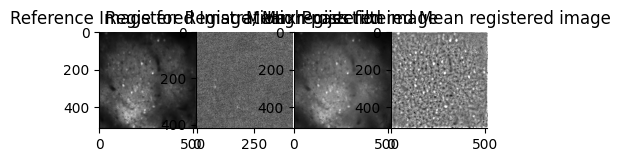

In [202]:
plt.subplot(1, 4, 1)

plt.imshow(output_ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

# maximum of recording over time
plt.subplot(1, 4, 2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

The rigid offsets of the frame from the reference are saved in `output_ops['yoff']` and `output_ops['xoff']`. The nonrigid offsets are saved in `output_ops['yoff1']` and `output_ops['xoff1']`, and each column is the offsets for a block (128 x 128 pixels by default).

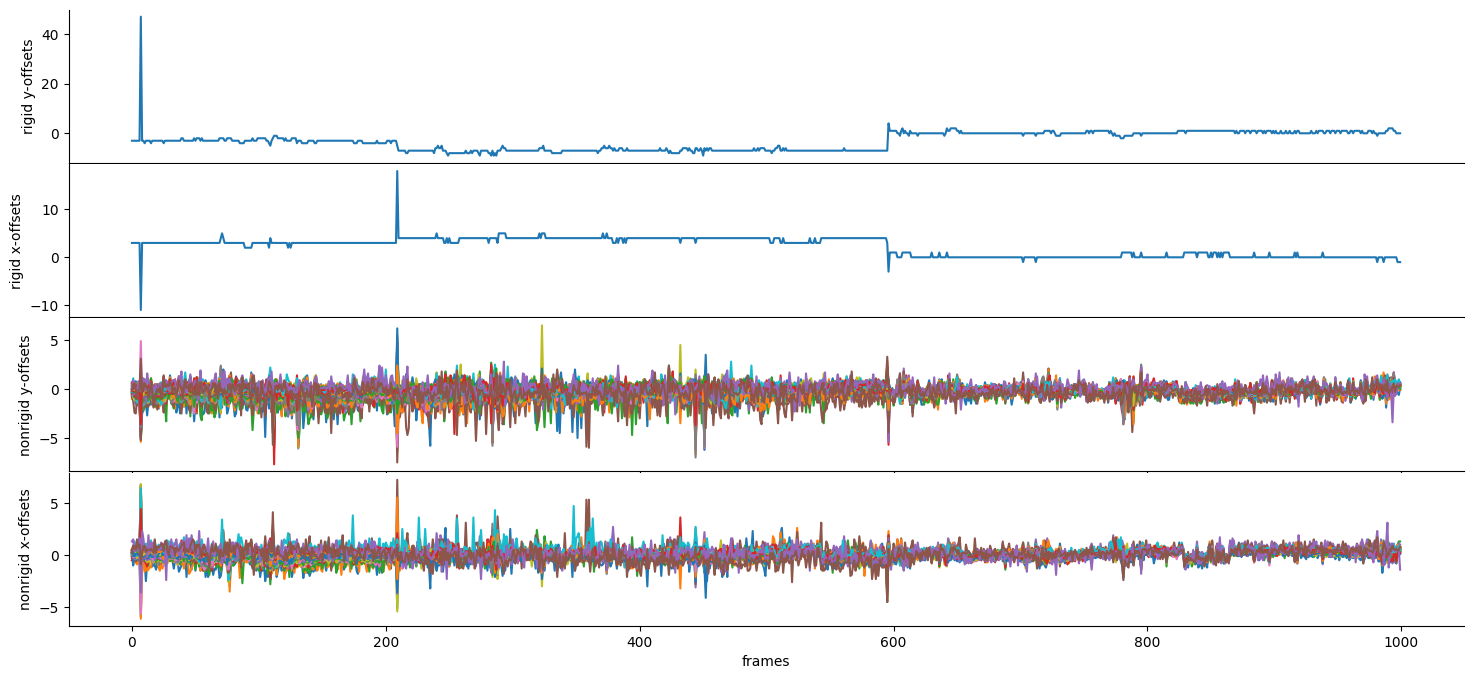

In [203]:
plt.figure(figsize=(18,8))

plt.subplot(4,1,1)
plt.plot(output_ops['yoff'][:1000])
plt.ylabel('rigid y-offsets')

plt.subplot(4,1,2)
plt.plot(output_ops['xoff'][:1000])
plt.ylabel('rigid x-offsets')

plt.subplot(4,1,3)
plt.plot(output_ops['yoff1'][:1000])
plt.ylabel('nonrigid y-offsets')

plt.subplot(4,1,4)
plt.plot(output_ops['xoff1'][:1000])
plt.ylabel('nonrigid x-offsets')
plt.xlabel('frames')

plt.show()


interactive(children=(IntSlider(value=2233, description='t', max=4466), Output()), _dom_classes=('widget-inter…

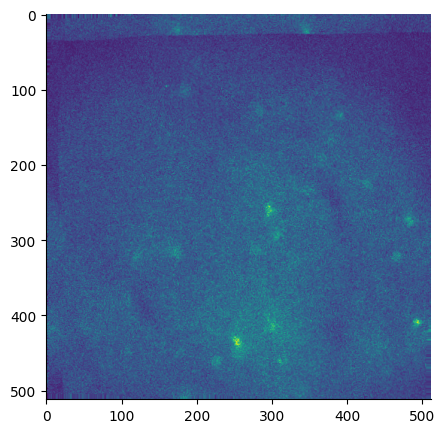

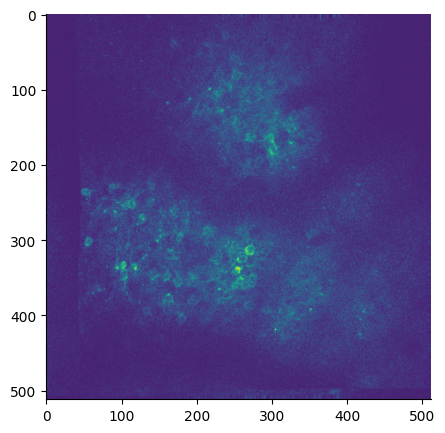

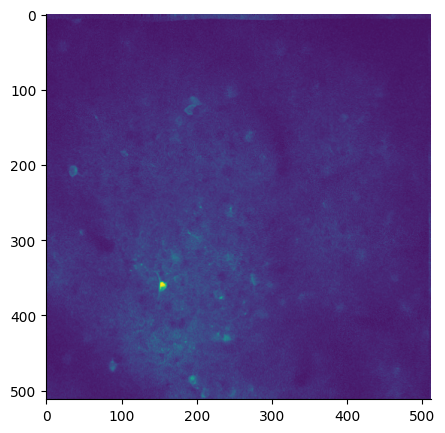

In [204]:
#@title Run cell to look at registered frames
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from suite2p.io import BinaryFile

widget = widgets.IntSlider(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


def plot_frame(t):
    with BinaryFile(Ly=output_ops['Ly'],
                Lx=output_ops['Lx'],
                filename=output_ops['reg_file']) as f:
        plt.imshow(f[t])

interact(plot_frame, t=(0, output_ops['nframes']- 1, 1)); # zero-indexed so have to subtract 1

Here in the notebook is not the best/fastest way to play the movie, you can play it in the suite2p GUI in the "View registered binary" player.

### Detection

Neurons are found by searching for sparse signals that are correlated spatially in the FOV. The ROIs are saved in `stat.npy` as a list of dictionaries which contain the pixels of the ROI and their weights (`stat['ypix']`, `stat['xpix']`, and `stat['lam']`). It also contains other spatial properties of the ROIs such as their aspect ratio and compactness, and properties of the signal such as the skewness of the fluorescence signal.


In [205]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(int)
stats = np.load(stats_file, allow_pickle=True)
print(stats[0].keys())

dict_keys(['ypix', 'xpix', 'lam', 'med', 'footprint', 'mrs', 'mrs0', 'compact', 'solidity', 'npix', 'npix_soma', 'soma_crop', 'overlap', 'radius', 'aspect_ratio', 'npix_norm_no_crop', 'npix_norm', 'skew', 'std', 'neuropil_mask'])


Neuronal cell body depending on their properties, like skewness, compactness, etc. Below we will visualize the ROIs, but please open the files in the ImageJ or suite2pGUI for closer inspection.

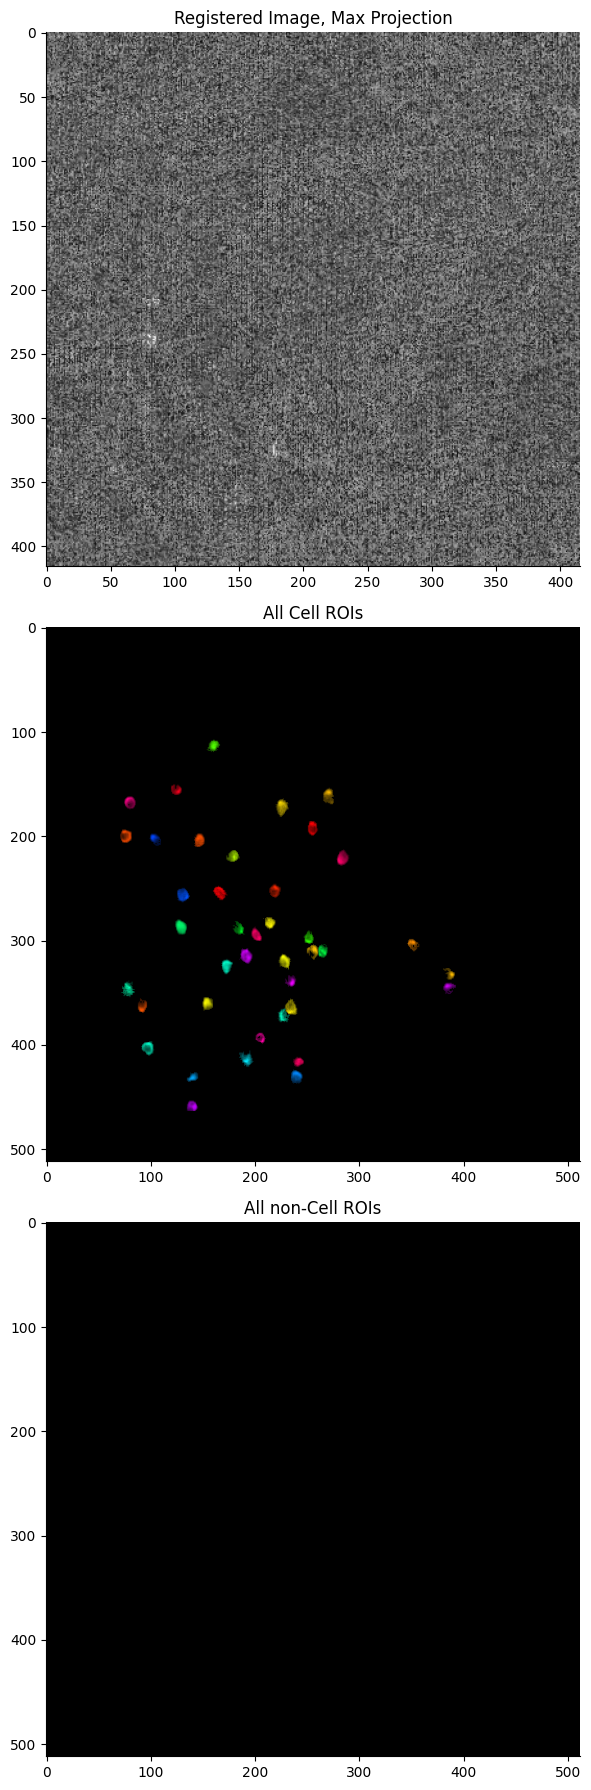

In [206]:
n_cells = len(stats)

h = np.random.rand(n_cells)
hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)

for i, stat in enumerate(stats):
    ypix, xpix, lam = stat['ypix'], stat['xpix'], stat['lam']
    hsvs[iscell[i], ypix, xpix, 0] = h[i]
    hsvs[iscell[i], ypix, xpix, 1] = 1
    hsvs[iscell[i], ypix, xpix, 2] = lam / lam.max()

from colorsys import hsv_to_rgb
rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)

plt.figure(figsize=(18,18))
plt.subplot(3, 1, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(3, 1, 2)
plt.imshow(rgbs[1])
plt.title("All Cell ROIs")

plt.subplot(3, 1, 3)
plt.imshow(rgbs[0])
plt.title("All non-Cell ROIs");

plt.tight_layout()

### Traces

We will load in the fluorescence, the neuropil and the deconvolved traces, and visualize them for a few cells.

In [207]:
f_cells = np.load(Path(output_ops['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_ops['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_ops['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neuropils.shape, spks.shape

((40, 4467), (40, 4467), (40, 4467))

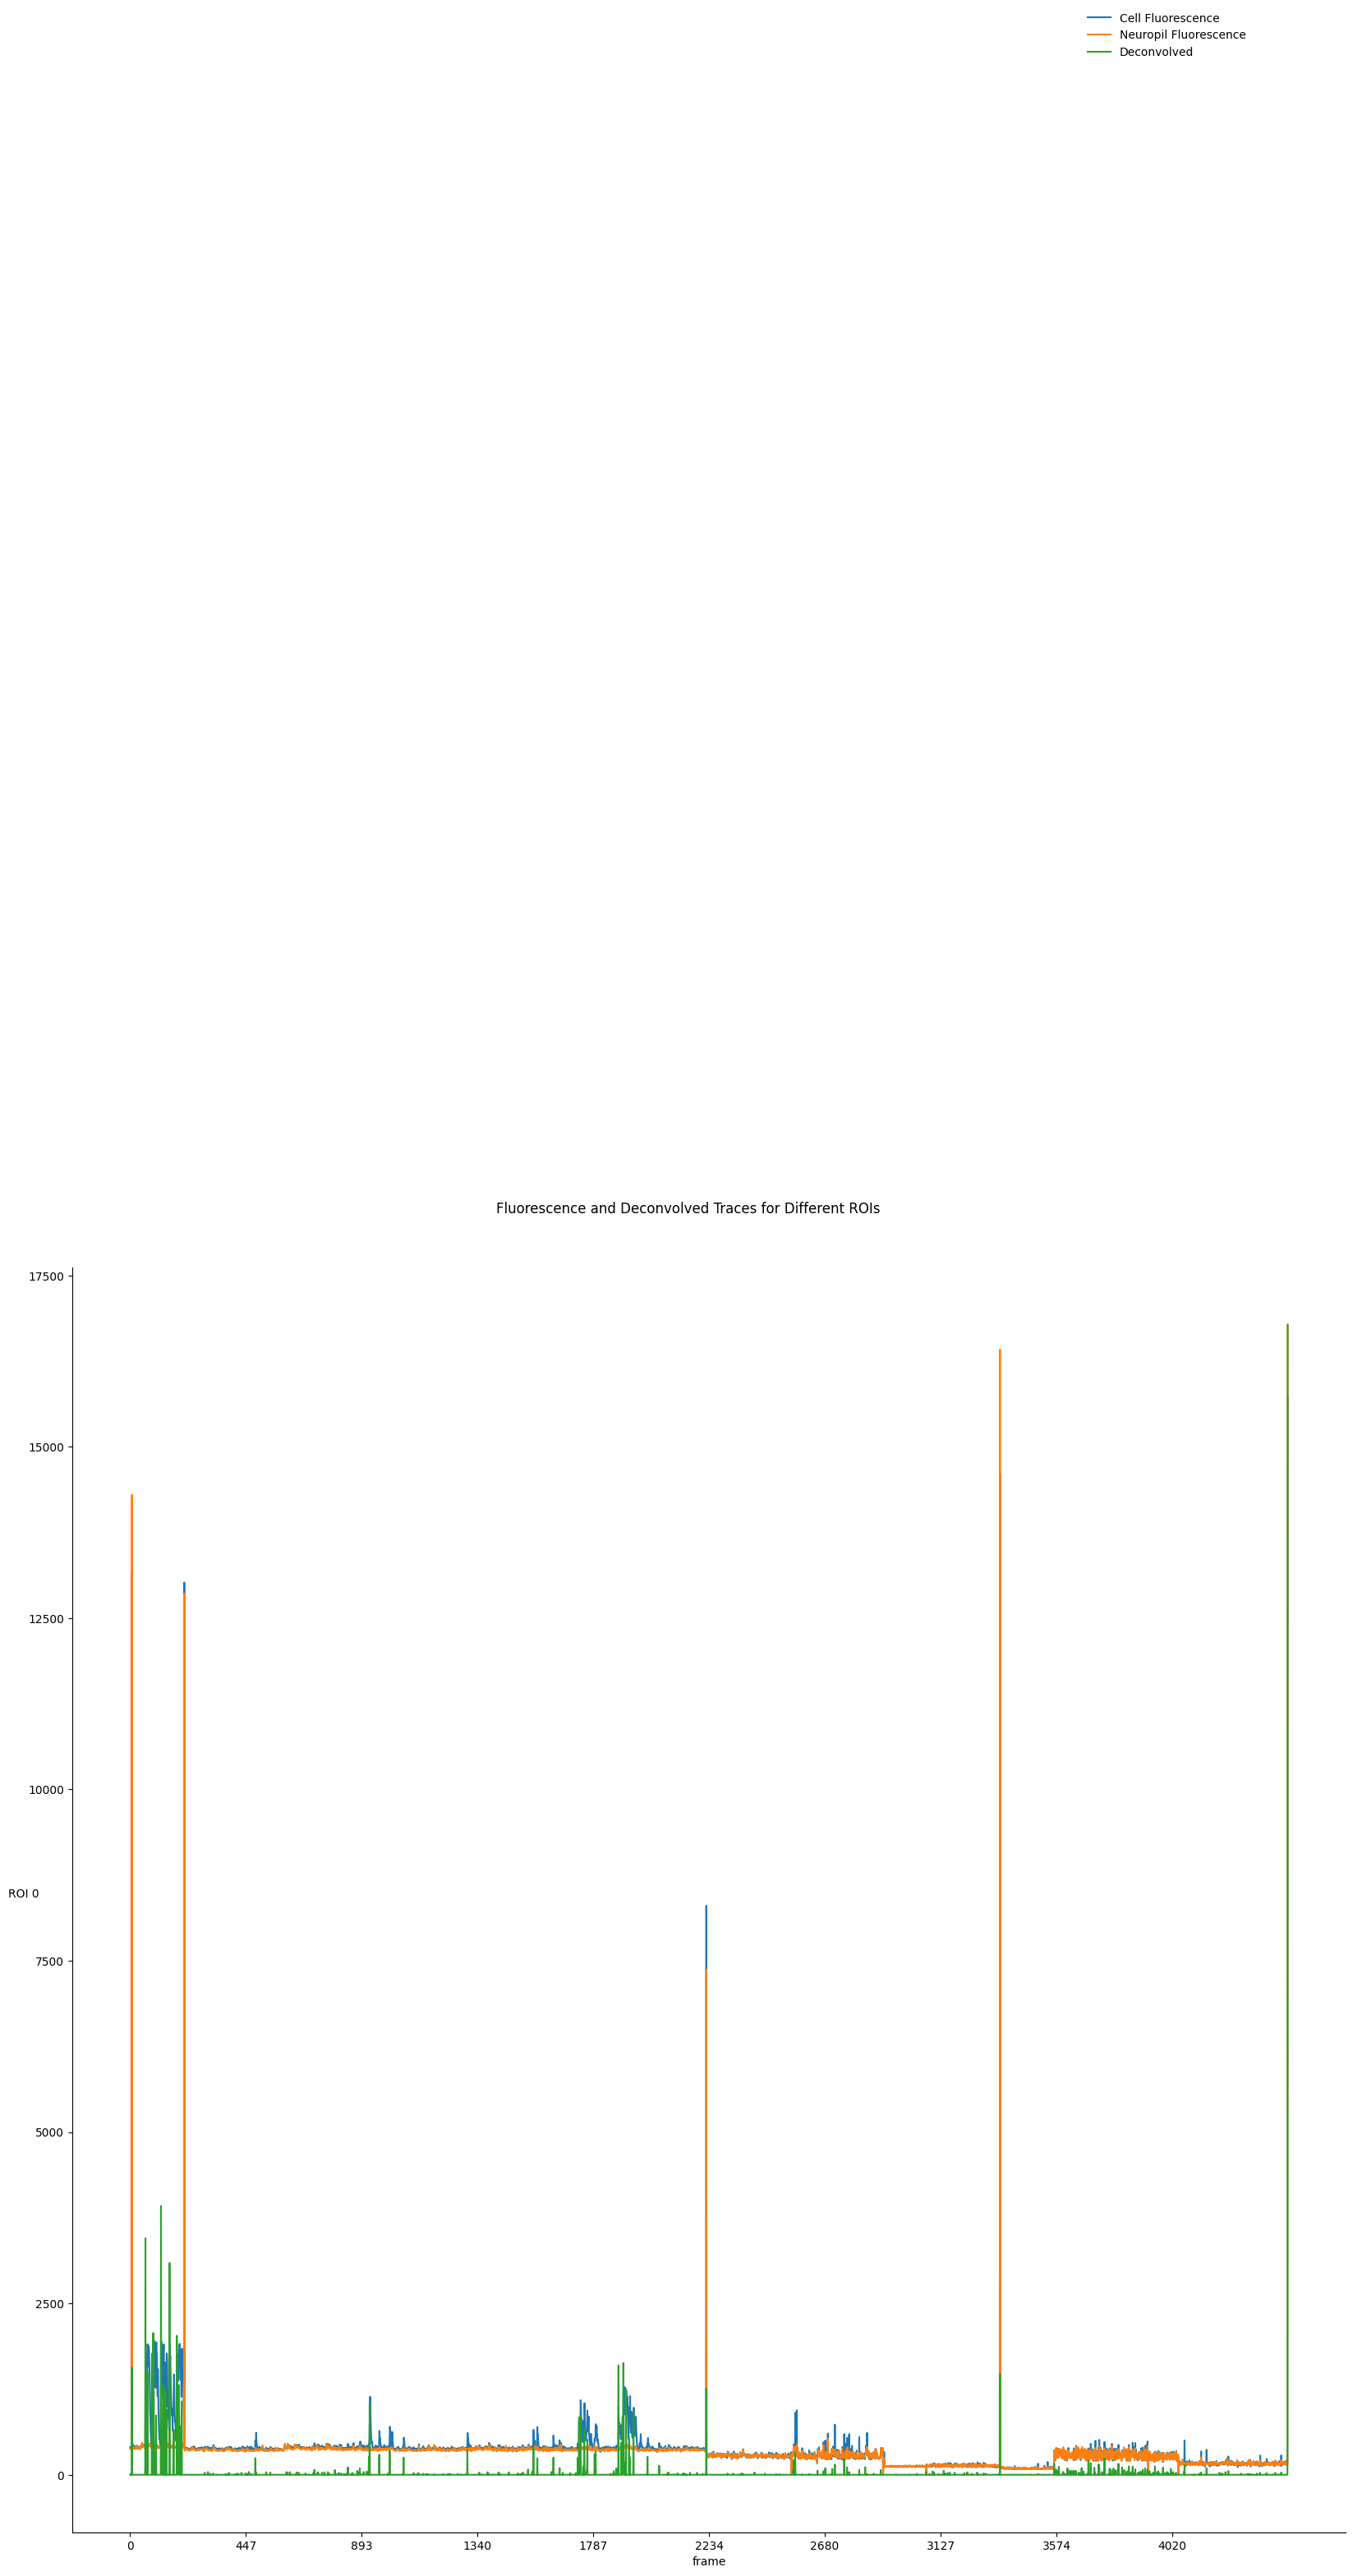

In [208]:
plt.figure(figsize=[20,20])
plt.suptitle("Fluorescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::200]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))